In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **IMPORTING REQUIRED MODULES**

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sb
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statistics import mean
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost as xg
!pip install scikit-surprise
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
from prettytable import PrettyTable

     |████████████████████████████████| 11.8 MB 50 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619412 sha256=d8a276279cc4777b1b21b679768035c9d7ffbf91113a1a3e09615067dd9843bf
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## **READING & PROCESSING THE DATA**

In [ ]:
'''movie_ids=[]
user_ids=[]
ratings=[]
dates=[]
for filenum in range(1,5):
  with open("/content/drive/MyDrive/Movie Recommendation System/data/combined_data_{}.txt".format(filenum)) as f:
    c1 = f.read().splitlines()
  for i in c1:
    if ":" in i:
      movie_id = i.split(":")[0]
    else:
      items = i.split(",")
      user_ids.append(items[0])
      movie_ids.append(movie_id)
      ratings.append(items[1])
      dates.append(items[2])
  pd.DataFrame({'User_id':user_ids,'Movie_id':movie_ids,'Rating':ratings,'Date':dates}).to_csv("/content/drive/MyDrive/Movie Recommendation System/data/c"+str(filenum)+".csv",index=False)'''

## **CONCATENATING ALL THE DATAFRAMES**

In [ ]:
'''d1 = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/data/c1.csv")
d2 = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/data/c2.csv")
d3 = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/data/c3.csv")
d4 = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/data/c4.csv")
data = pd.concat([d1,d2,d3,d4],axis=0)
data.head()'''

## **SAVING THE FINAL DATAFRAME**

In [ ]:
'''data.to_csv("/content/drive/MyDrive/Movie Recommendation System/data/data.csv",index=False)'''

## **PERFORMING EXPLORATORY DATA ANALYSIS (EDA)**

### **FIRST FIVE ROWS OF THE DATA**

In [ ]:
# Using limited data due to memory constraints
data = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/data/c1.csv")
data.head()

,User_id,Movie_id,Rating,Date
0,1488844,1,3,2005-09-06
1,822109,1,5,2005-05-13
2,885013,1,4,2005-10-19
3,30878,1,4,2005-12-26
4,823519,1,3,2004-05-03


#### **SORTING THE DATA BASED ON DATE COLUMN**

In [ ]:
data.sort_values(by=['Date'],inplace=True)
data.head()
# Since we have temporal data, we can train the model on past data and validate it on future data. Thus making our model more robust.

,User_id,Movie_id,Rating,Date
9056171,510180,1798,5,1999-11-11
14892677,510180,2866,3,1999-11-11
19585852,510180,3730,4,1999-11-11
20393918,510180,3870,2,1999-11-11
6901473,510180,1367,5,1999-11-11


In [ ]:
data.tail()

,User_id,Movie_id,Rating,Date
2804837,91133,501,3,2005-12-31
2153546,759638,406,1,2005-12-31
3789869,1536438,722,5,2005-12-31
5745901,1013110,1145,5,2005-12-31
10916395,589636,2126,5,2005-12-31


In [ ]:
data.shape

(24053764, 4)

#### **CHECK FOR EMPTY VALUES**

In [ ]:
data.isna().any() == True

User_id     False
Movie_id    False
Rating      False
Date        False
dtype: bool

#### **USERS AND MOVIES STATISTICS**

In [ ]:
print("Number of Users : ",len(set(data['User_id'].values)))
print("Number of Movies : ",len(set(data['Movie_id'].values)))

Number of Users :  470758
Number of Movies :  4499


#### **AVERAGE USER RATING**

In [ ]:
mean(data.groupby(['User_id'])['Rating'].agg('mean'))

3.678843334175959

#### **AVERAGE MOVIE RATING**

In [ ]:
mean(data.groupby(['Movie_id'])['Rating'].agg('mean'))

3.22194467751688

#### **RATING STATISTICS**

In [ ]:
data['Rating'].describe()

count    2.405376e+07
mean     3.599634e+00
std      1.086118e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

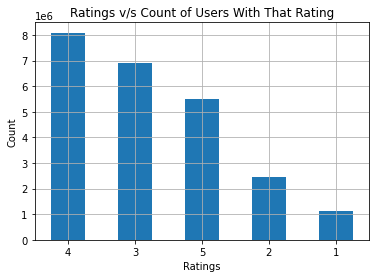

In [ ]:
data['Rating'].value_counts().plot(kind='bar')
plt.grid()
plt.xlabel("Ratings")
plt.xticks(rotation=360)
plt.ylabel("Count")
plt.title("Ratings v/s Count of Users With That Rating")
plt.show()

#### **INFERENCE**
 It seems that most of the movies/shows available in OTT are highly rated (ratings >= 3). It can be inferred that most of the users are satisfied with the content available in OTT.

#### **REVIEWS PER DAY-WISE**

In [ ]:
from datetime import datetime
days_count={}
rating_sum_day = {}
row_count = 0
for i in tqdm(data['Date'],leave=True,position=0):
  day = datetime.strptime(i,'%Y-%m-%d').strftime('%A')
  if day not in days_count:
    days_count[day]=1
  else:
    days_count[day]+=1
  if day not in rating_sum_day:
    rating_sum_day[day] = data.iloc[row_count,2]
  else:
    rating_sum_day[day]+=data.iloc[row_count,2]
  row_count+=1

100%|██████████| 24053764/24053764 [20:43<00:00, 19337.14it/s]


In [ ]:
avg_rating_day = {}
for i in days_count:
  avg_rating_day[i] = rating_sum_day[i]/days_count[i]
avg_rating_day

{'Friday': 3.5989619115677596,
 'Monday': 3.5940284325024265,
 'Saturday': 3.6099305612423804,
 'Sunday': 3.6116945614442004,
 'Thursday': 3.6002539998186953,
 'Tuesday': 3.5915895940760283,
 'Wednesday': 3.6002109420313726}

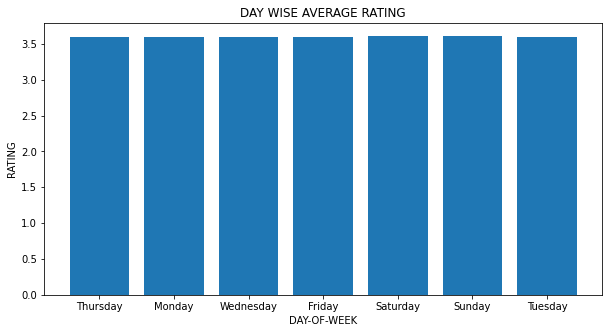

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(avg_rating_day.keys(),height=avg_rating_day.values())
plt.title("DAY WISE AVERAGE RATING")
plt.xlabel("DAY-OF-WEEK")
plt.ylabel("RATING")
plt.show()

#### **INFERENCE**
Seems that the rating of the user cannot be predicted with the feature "Day of the week" as the average rating for every day is almost similar

#### **TRAIN-TEST SPLIT**

In [ ]:
data.drop(columns=['Date'],inplace=True) # dropping the column Date
data.head()

,User_id,Movie_id,Rating
9056171,510180,1798,5
14892677,510180,2866,3
19585852,510180,3730,4
20393918,510180,3870,2
6901473,510180,1367,5


In [ ]:
# When shuffle = False the split happens in the order present in the original data
x_train,x_test = train_test_split(data,shuffle=False,train_size=0.90)
print("x_train.shape::",x_train.shape)
print("x_test.shape::",x_test.shape)

x_train.shape:: (21648387, 3)
x_test.shape:: (2405377, 3)


#### **NEW USERS PRESENT IN THE TEST DATA (TO KEEP AN EYE IN COLD START PROBLEM)**

In [ ]:
print("New Users present in the Test Data::",len(set(x_test['User_id']) - set(x_train['User_id'])))

New Users present in the Test Data:: 36337


#### **NEW MOVIES PRESENT IN THE TEST DATA**

In [ ]:
print("New Movies present in the Test Data::",len(set(x_test['Movie_id']) - set(x_train['Movie_id'])))

New Movies present in the Test Data:: 7


In [ ]:
set(x_test['Movie_id']) - set(x_train['Movie_id'])
#for these movies in the training spare mtx we have zero column vector..

{820, 946, 1445, 1979, 2426, 3251, 4362}

#### **INFERENCE**
The cold start problem is severe with User data, But not much siginificant with Movie records

#### **CONVERTING DATA INTO SPARSE MATRIX (ROWS - ALL USERS ; COLUMNS - ALL MOVIES)**

In [ ]:
row = x_train.User_id.values
col = x_train.Movie_id.values
data = x_train.Rating.values
x_train_csr = csr_matrix((data, (row, col)))
print("Shape of Sparse Training Data::",x_train_csr.shape)

Shape of Sparse Training Data:: (2649430, 4500)


In [ ]:
min(x_train.User_id.values),max(x_train.User_id.values),min(x_train.Movie_id.values),max(x_train.Movie_id.values)
# csr matrix takes the minimum value and maximum value and forms respective rows/columns sequentially 

(6, 2649429, 1, 4499)

In [ ]:
row2 = x_test.User_id.values
col2 = x_test.Movie_id.values
data2 = x_test.Rating.values
x_test_csr = csr_matrix((data2, (row2, col2)))
print("Shape of Sparse Test Data::",x_test_csr.shape)

Shape of Sparse Test Data:: (2649430, 4500)


In [ ]:
min(x_test.User_id.values),max(x_test.User_id.values),min(x_test.Movie_id.values),max(x_test.Movie_id.values)
# csr matrix takes the minimum value and maximum value and forms respective rows/columns sequentially 

(6, 2649429, 1, 4499)

## **APPLYING SIMILARITY TECHNIQUES**

#### **USER-USER SIMILARITY**

In [ ]:
def compute_sim_users(train_sparse_mtx,test_sparse_mtx,user_id,top_k):
  total_users = train_sparse_mtx.shape[0]
  given_user_vector = test_sparse_mtx.getrow(user_id)
  sim_list=[]
  for i in tqdm(range(total_users),leave=True,position=0):
    sim = cosine_similarity(train_sparse_mtx.getrow(i),given_user_vector)[0][0]
    sim_list.append((i,sim))
  sim_list.sort(key=lambda x:x[1],reverse=True)
  return sim_list[1:top_k+1] 
  # we are not taking first element bcoz, the top-most tuple would be the same user for whom similar users need to extracted

In [ ]:
# Generating top-10 similarities for a user with user-id 6.
user = 6
k = 10
compute_sim_users(x_train_csr,x_test_csr,user,k)

100%|██████████| 2649430/2649430 [42:11<00:00, 1046.66it/s]


[(2437284, 0.3260350450100612),
 (1614031, 0.30685651295064587),
 (251566, 0.29381252971228683),
 (358270, 0.29246987201388674),
 (2097870, 0.28869465219968926),
 (2013547, 0.2880772565599833),
 (1128340, 0.2876779808912305),
 (1546827, 0.2833047711233617),
 (59550, 0.27467088694244846),
 (272287, 0.27373633633139305)]

#### **INFERENCE**
Even for a single user (to generate top-10 similar users) the computational complexity for USER-USER Similarity approach is too high. So this could not be the best possible technique for generating recommendations

#### **MOVIE-MOVIE SIMILARITY (ITEM-ITEM)**

In [ ]:
movie_names = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/data/movie_titles.csv",header=None,
                          encoding = "ISO-8859-1",names=['Movie_id','Release_Year','Movie_Name'])
movie_names.head()

,Movie_id,Release_Year,Movie_Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [ ]:
def compute_sim_movies(train_sparse_mtx,test_sparse_mtx,movie_id,top_k):
  m1 = test_sparse_mtx.T # shape will be 4500 x A 
  print("Shape of m1:",m1.shape)
  print("Shape of train_sparse_mtx:",train_sparse_mtx.shape)
  sim_mtx_movie = np.dot(m1,train_sparse_mtx)
  print("Shape of MOVIE-MOVIE Similarity Matrix : ", sim_mtx_movie.shape)
  sim_movie_ids = sim_mtx_movie.getrow(movie_id).toarray()[0].argsort()[-top_k:][::-1].tolist()
  return sim_movie_ids

In [ ]:
start = datetime.now()
k = 5 # Top-k Movies
movie = 2 # Movie-id
sim_movie_ids = compute_sim_movies(x_train_csr,x_test_csr,movie,k)
print("Movies Similar to the given movie '{}' are..".format(movie_names[movie_names.Movie_id == movie]['Movie_Name'].values[0]))
movie_names[movie_names.Movie_id.isin(sim_movie_ids)]

Shape of m1: (4500, 2649430)
Shape of train_sparse_mtx: (2649430, 4500)
Shape of MOVIE-MOVIE Similarity Matrix :  (4500, 4500)
Movies Similar to the given movie 'Isle of Man TT 2004 Review' are..


,Movie_id,Release_Year,Movie_Name
456,457,2004.0,Kill Bill: Vol. 2
1219,1220,2004.0,Man on Fire
1904,1905,2003.0,Pirates of the Caribbean: The Curse of the Bla...
2371,2372,2004.0,The Bourne Supremacy
3623,3624,2003.0,The Last Samurai


#### **INFERENCE**
Compared to USER-USER Similarity approach, the MOVIE-MOVIE similarity approach is faster and also provides decent results. So this could be potential non-ML model that can be used for generating recommendations. (Using The complete Data could Provide us even more good results)

## **APPLYING MACHINE LEARNING MODELS**

#### **BUILDING HANDCRAFTED FEATURES**

###### **BUILDING AND SAVING MOVIE-MOVIE SIMILARITY MATRIX**

In [ ]:
path = "/content/drive/MyDrive/Movie Recommendation System/"

In [ ]:
'''mm_sim_mtx = np.dot(x_train_csr.T,x_train_csr)
print("Shape of Movie-Movie Similarity Matrix : ",mm_sim_mtx.shape)'''

Shape of Movie-Movie Similarity Matrix :  (4500, 4500)


In [ ]:
'''pickling_on = open(path+"movie_movie_sim_mtx.pkl","wb")
pickle.dump(mm_sim_mtx, pickling_on)
pickling_on.close()
print("Done Saving The Matrix..")'''

Done Saving The Matrix..


In [ ]:
import pickle
temp = open("/content/drive/MyDrive/Movie Recommendation System/movie_movie_sim_mtx.pkl","rb")
mm_sim_mtx = pickle.load(temp)
mm_sim_mtx.shape

(4500, 4500)

###### **BUILDING FEATURES**

#####F1 = > Global Average of the rating in the training set
#####F2 = > Given user average Rating
#####F3 = > Given movie average Rating
#####F4-F8 = > Ratings of top-5 similar movies rated by the given user.

In [ ]:
x_train.head()

,User_id,Movie_id,Rating
9056171,510180,1798,5
14892677,510180,2866,3
19585852,510180,3730,4
20393918,510180,3870,2
6901473,510180,1367,5


###### **COMPUTING FEATURE-1 : GLOBAL AVERAGE RATING**

In [ ]:
# finding global average rating
f1_gavg=round(sum(x_train['Rating'])/x_train.shape[0],3)
print("Global Average Movie Rating : ",f1_gavg)

Global Average Movie Rating :  3.589


In [ ]:
x_train['Gavg'] = f1_gavg
x_train.head()

,User_id,Movie_id,Rating,Gavg
9056171,510180,1798,5,3.589
14892677,510180,2866,3,3.589
19585852,510180,3730,4,3.589
20393918,510180,3870,2,3.589
6901473,510180,1367,5,3.589


###### **COMPUTING FEATURE-2 : USER AVERAGE RATING**

In [ ]:
x_train['Rating_Sum'] = x_train['Rating'].groupby(x_train['User_id']).transform('sum')
x_train.head()

,User_id,Movie_id,Rating,Gavg,Rating_Sum
9056171,510180,1798,5,3.589,781
14892677,510180,2866,3,3.589,781
19585852,510180,3730,4,3.589,781
20393918,510180,3870,2,3.589,781
6901473,510180,1367,5,3.589,781


In [ ]:
x_train['User_id_sum'] = x_train['User_id'].groupby(x_train['User_id']).transform('sum')
x_train.head()

,User_id,Movie_id,Rating,Gavg,Rating_Sum,User_id_sum
9056171,510180,1798,5,3.589,781,118361760
14892677,510180,2866,3,3.589,781,118361760
19585852,510180,3730,4,3.589,781,118361760
20393918,510180,3870,2,3.589,781,118361760
6901473,510180,1367,5,3.589,781,118361760


In [ ]:
x_train['Count'] = x_train['User_id_sum']/x_train['User_id']
x_train.head()

,User_id,Movie_id,Rating,Gavg,Rating_Sum,User_id_sum,Count
9056171,510180,1798,5,3.589,781,118361760,232.0
14892677,510180,2866,3,3.589,781,118361760,232.0
19585852,510180,3730,4,3.589,781,118361760,232.0
20393918,510180,3870,2,3.589,781,118361760,232.0
6901473,510180,1367,5,3.589,781,118361760,232.0


In [ ]:
x_train['Average_user_rating'] = round(x_train['Rating_Sum']/x_train['Count'],3)
x_train.drop(columns=['User_id_sum','Rating_Sum','Count'],inplace=True)
x_train.head()

,User_id,Movie_id,Rating,Gavg,Average_user_rating
9056171,510180,1798,5,3.589,3.366
14892677,510180,2866,3,3.589,3.366
19585852,510180,3730,4,3.589,3.366
20393918,510180,3870,2,3.589,3.366
6901473,510180,1367,5,3.589,3.366


###### **COMPUTING FEATURE-3 : MOVIE AVERAGE RATING**

In [ ]:
x_train['Movie_Rating_Sum'] = x_train['Rating'].groupby(x_train['Movie_id']).transform('sum')
x_train.head()

,User_id,Movie_id,Rating,Gavg,Average_user_rating,Movie_Rating_Sum
9056171,510180,1798,5,3.589,3.366,408136
14892677,510180,2866,3,3.589,3.366,68804
19585852,510180,3730,4,3.589,3.366,141322
20393918,510180,3870,2,3.589,3.366,26387
6901473,510180,1367,5,3.589,3.366,83381


In [ ]:
x_train['Movie_id_sum'] = x_train['Movie_id'].groupby(x_train['Movie_id']).transform('sum')
x_train.head()

,User_id,Movie_id,Rating,Gavg,Average_user_rating,Movie_Rating_Sum,Movie_id_sum
9056171,510180,1798,5,3.589,3.366,408136,185440326
14892677,510180,2866,3,3.589,3.366,68804,57767096
19585852,510180,3730,4,3.589,3.366,141322,133299010
20393918,510180,3870,2,3.589,3.366,26387,32124870
6901473,510180,1367,5,3.589,3.366,83381,31771814


In [ ]:
x_train['Movie_Count'] = x_train['Movie_id_sum']/x_train['Movie_id']
x_train.head()

,User_id,Movie_id,Rating,Gavg,Average_user_rating,Movie_Rating_Sum,Movie_id_sum,Movie_Count
9056171,510180,1798,5,3.589,3.366,408136,185440326,103137.0
14892677,510180,2866,3,3.589,3.366,68804,57767096,20156.0
19585852,510180,3730,4,3.589,3.366,141322,133299010,35737.0
20393918,510180,3870,2,3.589,3.366,26387,32124870,8301.0
6901473,510180,1367,5,3.589,3.366,83381,31771814,23242.0


In [ ]:
x_train['Average_movie_rating'] = round(x_train['Movie_Rating_Sum']/x_train['Movie_Count'],3)
x_train.drop(columns=['Movie_Rating_Sum','Movie_id_sum','Movie_Count'],inplace=True)
x_train.head()

,User_id,Movie_id,Rating,Gavg,Average_user_rating,Average_movie_rating
9056171,510180,1798,5,3.589,3.366,3.957
14892677,510180,2866,3,3.589,3.366,3.414
19585852,510180,3730,4,3.589,3.366,3.955
20393918,510180,3870,2,3.589,3.366,3.179
6901473,510180,1367,5,3.589,3.366,3.588


In [ ]:
'''x_train.to_csv(path+"wout_sim_movie_ratings.csv",index=False)'''

In [ ]:
import pandas as pd
path = "/content/drive/MyDrive/Movie Recommendation System/"
x_train = pd.read_csv(path+"Final_Train_Features.csv")
x_train.head()

,User_id,Movie_id,Rating,Gavg,Average_user_rating,Average_movie_rating,sim_movie_1_rating,sim_movie_2_rating,sim_movie_3_rating,sim_movie_4_rating,sim_movie_5_rating
0,510180,1798,5,3.589,3.366,3.957,3.0,5.0,4.0,4.0,4.0
1,510180,2866,3,3.589,3.366,3.414,5.0,3.0,4.0,4.0,4.0
2,510180,3730,4,3.589,3.366,3.955,4.0,5.0,3.0,5.0,4.0
3,510180,3870,2,3.589,3.366,3.179,2.0,4.0,5.0,4.0,3.0
4,510180,1367,5,3.589,3.366,3.588,5.0,4.0,5.0,4.0,3.0


###### **COMPUTING FEATURE-4 to 8 : Ratings of top-5 similar movies rated by the given user**

In [ ]:
uids = x_train['User_id'].values
mids = x_train['Movie_id'].values
ratings = x_train['Rating'].values

In [ ]:
user_movie_rating = {}
for uid,mid,rat in zip(uids,mids,ratings):
  user_movie_rating[(uid,mid)] = rat

In [ ]:
from tqdm import tqdm
sim_movies={}
for mid in tqdm(set(mids)):
  top_30_sim_movies = list(mm_sim_mtx.getrow(mid).toarray()[0].argsort()[-31:][::-1][1:])
  sim_movies[mid] = top_30_sim_movies

100%|██████████| 4492/4492 [05:54<00:00, 12.66it/s]


In [ ]:
user_rat_sim_movies=[]
for i,j in tqdm(zip(uids,mids)):
  l=[]
  sim_movies_30 = sim_movies[j]
  for k in sim_movies_30:
    if (i,k) in user_movie_rating:
      rati = user_movie_rating[(i,k)]
      l.append(rati)
  user_rat_sim_movies.append(l[0:5]) 
  # 92% of the data has 5 sized Non-Zero involved vectors, for remaining 8% of the data avg rating of that user is added

21648387it [13:25, 26874.49it/s]


In [ ]:
for i in tqdm(user_rat_sim_movies):
  if len(i)!=5:
    while(len(i)!=5):
      i.append(0)

100%|██████████| 21648387/21648387 [00:09<00:00, 2263514.80it/s]


In [ ]:
'''path = "/content/drive/MyDrive/Movie Recommendation System/"
pickling_on = open(path+"user_rating_for_sim_movies_2.pkl","wb")
pickle.dump(user_rat_sim_movies, pickling_on)
pickling_on.close()
print("Done Saving The List of vectors..")'''

In [ ]:
temp = open("/content/drive/MyDrive/Movie Recommendation System/user_rating_for_sim_movies.pkl","rb")
user_rat_sim_movies = pickle.load(temp)

In [ ]:
temp = pd.DataFrame(columns=['sim_movie_1_rating','sim_movie_2_rating','sim_movie_3_rating',\
                             'sim_movie_4_rating','sim_movie_5_rating'],index=x_train.index)
for i in tqdm(range(x_train.shape[0])):
  temp.loc[i] = user_rat_sim_movies[i]
print("\n",temp.shape)

100%|██████████| 21648387/21648387 [26:18<00:00, 13718.48it/s]


 (21648387, 5)


In [ ]:
temp.to_csv(path+"train_sim_movie_rating_vecs.csv",index=False)

In [ ]:
temp = pd.read_csv(path+"train_sim_movie_rating_vecs.csv")
temp.head()

,sim_movie_1_rating,sim_movie_2_rating,sim_movie_3_rating,sim_movie_4_rating,sim_movie_5_rating
0,3,5,4,4,4
1,5,3,4,4,4
2,4,5,3,5,4
3,2,4,5,4,3
4,5,4,5,4,3


###### **SAVING FINAL TRAINING DATA WITH HAND CRAFTED FEATURES**

In [ ]:
train_data_feat = pd.concat([x_train,temp],axis=1)
#make axis=1 & concatenate

In [ ]:
# When user only watched k movies (k<5) out of top-30 similar movies remaining 5-k values are replaced by the user average rating value
# (Because as we consider more and more similar movies the similarity between the given movie and consdiered movie decreases. So i went 
# with that user's average rating)  

train_data_feat['sim_movie_1_rating'] = np.where(train_data_feat['sim_movie_1_rating'] == 0,train_data_feat['Average_user_rating'],
                                                 train_data_feat['sim_movie_1_rating'])
train_data_feat['sim_movie_2_rating'] = np.where(train_data_feat['sim_movie_2_rating'] == 0,train_data_feat['Average_user_rating'],
                                                 train_data_feat['sim_movie_2_rating'])
train_data_feat['sim_movie_3_rating'] = np.where(train_data_feat['sim_movie_3_rating'] == 0,train_data_feat['Average_user_rating'],
                                                 train_data_feat['sim_movie_3_rating'])
train_data_feat['sim_movie_4_rating'] = np.where(train_data_feat['sim_movie_4_rating'] == 0,train_data_feat['Average_user_rating'],
                                                 train_data_feat['sim_movie_4_rating'])
train_data_feat['sim_movie_5_rating'] = np.where(train_data_feat['sim_movie_5_rating'] == 0,train_data_feat['Average_user_rating'],
                                                 train_data_feat['sim_movie_5_rating'])

In [ ]:
train_data_feat.to_csv("/content/drive/MyDrive/Movie Recommendation System/Final_Train_Features.csv",)

In [ ]:
train_data_feat = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/Final_Train_Features.csv")
train_data_feat.head()

,User_id,Movie_id,Rating,Gavg,Average_user_rating,Average_movie_rating,sim_movie_1_rating,sim_movie_2_rating,sim_movie_3_rating,sim_movie_4_rating,sim_movie_5_rating
0,510180,1798,5,3.589,3.366,3.957,3.0,5.0,4.0,4.0,4.0
1,510180,2866,3,3.589,3.366,3.414,5.0,3.0,4.0,4.0,4.0
2,510180,3730,4,3.589,3.366,3.955,4.0,5.0,3.0,5.0,4.0
3,510180,3870,2,3.589,3.366,3.179,2.0,4.0,5.0,4.0,3.0
4,510180,1367,5,3.589,3.366,3.588,5.0,4.0,5.0,4.0,3.0


In [ ]:
user_avg_rating = {}
for uid,avgurat in tqdm(zip(train_data_feat['User_id'],train_data_feat['Average_user_rating'])):
  user_avg_rating[uid] = avgurat

21648387it [00:18, 1151357.53it/s]


In [ ]:
movie_avg_rating = {}
for mid,avgmrat in tqdm(zip(train_data_feat['Movie_id'],train_data_feat['Average_movie_rating'])):
  movie_avg_rating[mid] = avgmrat

21648387it [00:14, 1445506.92it/s]


In [ ]:
'''pickling_on = open("/content/drive/MyDrive/Movie Recommendation System/"+"movie_average_rating.pkl","wb")
pickle.dump(movie_avg_rating, pickling_on)
pickling_on.close()
print("Done Saving..")'''

Done Saving..


###### **BUILDING TEST VECTORS**

In [ ]:
x_test.head()

,User_id,Movie_id,Rating
2982572,1289218,560,5
7465184,1969526,1488,4
2162493,1853810,406,4
17197390,1046647,3315,4
7465183,1984358,1488,2


###### **ADDING FEATURE - 1 : GLOBAL AVERAGE MOVIE RATING (HERE WE TAKE TRAINING DATA GLOBAL AVERAGE)**

In [ ]:
x_test['Global_avg'] = 3.589
x_test.head()

,User_id,Movie_id,Rating,Global_avg
2982572,1289218,560,5,3.589
7465184,1969526,1488,4,3.589
2162493,1853810,406,4,3.589
17197390,1046647,3315,4,3.589
7465183,1984358,1488,2,3.589


###### **ADDING FEATURE - 2 & FEATURE -3 : Average User Rating & Average Movie Rating**

In [ ]:
temp = open("/content/drive/MyDrive/Movie Recommendation System/user_average_rating.pkl","rb")
user_avg_rating = pickle.load(temp)
temp = open("/content/drive/MyDrive/Movie Recommendation System/movie_average_rating.pkl","rb")
movie_avg_rating = pickle.load(temp)

def create_avg_feat(dataframe,colname,dictionary):
  l = []
  for i in tqdm(dataframe[colname]):
    try:
      l.append(dictionary[i])
    except: # cold start problem handling (if user not present in the training set)
      l.append(0)
  return l
user_avg_rating_list = create_avg_feat(x_test,'User_id',user_avg_rating)
movie_avg_rating_list = create_avg_feat(x_test,'Movie_id',movie_avg_rating)

100%|██████████| 2405377/2405377 [00:01<00:00, 1823282.22it/s]


In [ ]:
x_test['User_avg_rating'] = user_avg_rating_list
x_test['Movie_avg_rating'] = movie_avg_rating_list
x_test.head()

,User_id,Movie_id,Rating,Global_avg,User_avg_rating,Movie_avg_rating
2982572,1289218,560,5,3.589,3.219,4.086
7465184,1969526,1488,4,3.589,3.765,3.926
2162493,1853810,406,4,3.589,3.333,3.784
17197390,1046647,3315,4,3.589,3.842,4.030
7465183,1984358,1488,2,3.589,3.164,3.926


In [ ]:
x_test.to_csv("/content/drive/MyDrive/Movie Recommendation System/test_data_without_sim_movies_vec.csv",index=False)

In [ ]:
x_test = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/test_data_without_sim_movies_vec.csv")
x_test.head()

,User_id,Movie_id,Rating,Global_avg,User_avg_rating,Movie_avg_rating
0,1289218,560,5,3.589,3.219,4.086
1,1969526,1488,4,3.589,3.765,3.926
2,1853810,406,4,3.589,3.333,3.784
3,1046647,3315,4,3.589,3.842,4.030
4,1984358,1488,2,3.589,3.164,3.926


#### **BUILDING TEST VECTORS**

In [ ]:
new_users =  set(x_test[(x_test['User_avg_rating']==0)]['User_id'].values)
new_movies = set(x_test[(x_test['Movie_avg_rating']==0)]['Movie_id'].values)

In [ ]:
temp = open("/content/drive/MyDrive/Movie Recommendation System/user_average_rating.pkl","rb")
user_avg_rating = pickle.load(temp)

#### **Handling Cold-Start Problem**
* When we have a new user in the test data (who watched only one movie and has no historical data). The similar movies vector and average rating of that user will be all zeroes.

* When we have a new movie in the system (which has no historical data of ratings and may also not be similar to any other movie) then the similar movies vector will be a vector of that user's average ratings.

* If a user watched less than 5 similar movies to that of a given movie then remaining values will be filled by that user's average rating.


In [ ]:
uids_test = x_test['User_id'].values
mids_test = x_test['Movie_id'].values
user_rat_sim_movies_test=[]
for i,j in tqdm(zip(uids_test,mids_test)):
  if i in new_users:
    l = [0,0,0,0,0]
  elif j in new_movies:
    avg_rating_user = user_avg_rating[i]
    l = [avg_rating_user,avg_rating_user,avg_rating_user,avg_rating_user,avg_rating_user]
  else:
    l=[]
    sim_movies_30 = sim_movies[j]
    for k in sim_movies_30:
      if (i,k) in user_movie_rating:
        rati = user_movie_rating[(i,k)]
        l.append(rati)
  l_length = len(l) 
  if l_length<5:
    req = 5-l_length
    for li in range(req):
      l.append(user_avg_rating[i])
  user_rat_sim_movies_test.append(l[0:5])

2405377it [01:00, 39714.60it/s]


In [ ]:
temp_test = pd.DataFrame(columns=['sim_movie_1_rating','sim_movie_2_rating','sim_movie_3_rating',\
                             'sim_movie_4_rating','sim_movie_5_rating'],index=x_test.index)
for i in tqdm(range(x_test.shape[0])):
  temp_test.loc[i] = user_rat_sim_movies_test[i]
print("\n",temp_test.shape)

100%|██████████| 2405377/2405377 [02:56<00:00, 13646.59it/s]


 (2405377, 5)


In [ ]:
temp_test

,sim_movie_1_rating,sim_movie_2_rating,sim_movie_3_rating,sim_movie_4_rating,sim_movie_5_rating
0,4,5,5,5,5
1,4,5,4,3,4
2,4,4,3,4,3
3,5,5,5,3,3
4,2,4,5,4,3
...,...,...,...,...,...
2405372,4,3,3,5,3
2405373,5,1,5,1,1
2405374,4,5,4,5,4
2405375,0,0,0,0,0


In [ ]:
test_data_feat = pd.concat([x_test,temp_test],axis=1)

In [ ]:
test_data_feat.head(10)

,User_id,Movie_id,Rating,Global_avg,User_avg_rating,Movie_avg_rating,sim_movie_1_rating,sim_movie_2_rating,sim_movie_3_rating,sim_movie_4_rating,sim_movie_5_rating
0,1289218,560,5,3.589,3.219,4.086,4,5,5,5,5
1,1969526,1488,4,3.589,3.765,3.926,4,5,4,3,4
2,1853810,406,4,3.589,3.333,3.784,4,4,3,4,3
3,1046647,3315,4,3.589,3.842,4.030,5,5,5,3,3
4,1984358,1488,2,3.589,3.164,3.926,2,4,5,4,3
5,1903453,1488,4,3.589,3.688,3.926,4,4,3.688,3.688,3.688
6,96572,4043,5,3.589,3.377,3.495,4,5,5,5,5
7,741818,406,4,3.589,3.330,3.784,4,4,3,4,4
8,1382430,345,4,3.589,3.432,4.113,5,5,4,5,3
9,1530485,457,5,3.589,4.125,3.876,4,4.125,4.125,4.125,4.125


In [ ]:
test_data_feat.to_csv("/content/drive/MyDrive/Movie Recommendation System/Final_Test_Features.csv",index=False)

## **LOADING FINAL TRAIN AND TEST DATASETS**

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/Final_Train_Features.csv")
test = pd.read_csv("/content/drive/MyDrive/Movie Recommendation System/Final_Test_Features.csv")

In [ ]:
train.head()

,User_id,Movie_id,Rating,Gavg,Average_user_rating,Average_movie_rating,sim_movie_1_rating,sim_movie_2_rating,sim_movie_3_rating,sim_movie_4_rating,sim_movie_5_rating
0,510180,1798,5,3.589,3.366,3.957,3.0,5.0,4.0,4.0,4.0
1,510180,2866,3,3.589,3.366,3.414,5.0,3.0,4.0,4.0,4.0
2,510180,3730,4,3.589,3.366,3.955,4.0,5.0,3.0,5.0,4.0
3,510180,3870,2,3.589,3.366,3.179,2.0,4.0,5.0,4.0,3.0
4,510180,1367,5,3.589,3.366,3.588,5.0,4.0,5.0,4.0,3.0


In [ ]:
test.head()

,User_id,Movie_id,Rating,Global_avg,User_avg_rating,Movie_avg_rating,sim_movie_1_rating,sim_movie_2_rating,sim_movie_3_rating,sim_movie_4_rating,sim_movie_5_rating
0,1289218,560,5,3.589,3.219,4.086,4.0,5.0,5.0,5.0,5.0
1,1969526,1488,4,3.589,3.765,3.926,4.0,5.0,4.0,3.0,4.0
2,1853810,406,4,3.589,3.333,3.784,4.0,4.0,3.0,4.0,3.0
3,1046647,3315,4,3.589,3.842,4.030,5.0,5.0,5.0,3.0,3.0
4,1984358,1488,2,3.589,3.164,3.926,2.0,4.0,5.0,4.0,3.0


## **APPLYING XGBOOST REGRESSOR**

In [ ]:
x_train = train[['Gavg','Average_user_rating','Average_movie_rating','sim_movie_1_rating','sim_movie_2_rating',
                                  'sim_movie_3_rating','sim_movie_4_rating','sim_movie_5_rating']].values
y_train = train[['Rating']].values.ravel()
x_test = test[['Global_avg','User_avg_rating','Movie_avg_rating','sim_movie_1_rating','sim_movie_2_rating',
                                  'sim_movie_3_rating','sim_movie_4_rating','sim_movie_5_rating']].values
y_test =  test[['Rating']].values.ravel()

In [ ]:
xgb_r = xg.XGBRegressor(objective='reg:linear',n_estimators=10,random_state=0)
xgb_r.fit(x_train,y_train)

In [ ]:
print("RMSE Value on Test Data : ",np.sqrt(mean_squared_error(y_test,xgb_r.predict(x_test))))

RMSE Value on Test Data :  1.6799188772496727


## **PREDICTION USING SVD - 25 FACTORS**

In [ ]:
def compute_perf(svd,test,fac):
  rat_pred = []
  rat_true = []
  for uid,mid,rat in zip(test['User_id'],test['Movie_id'],test['Rating']):
    rat_pred.append(svd.predict(uid=uid,iid=mid)[3])
    rat_true.append(rat)
  print("RMSE ON TEST DATA (Using SVD-{}) : {}".format(fac,np.sqrt(mean_squared_error(rat_true,rat_pred))))
  return rat_pred

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['User_id','Movie_id','Rating']],reader)
svd_25 = SVD(verbose=True, n_epochs=10,n_factors=25)
trainset = data.build_full_trainset()
svd_25.fit(trainset)
print("Training Done..!!")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Training Done..!!


In [ ]:
pred_rat_svd_25 = compute_perf(svd_25,test,25)

RMSE ON TEST DATA (Using SVD-25 factors) :  0.9760240635034816


## **SVD MODEL WITH 100 FACTORS**

In [ ]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(train[['User_id','Movie_id','Rating']],reader)
svd = SVD(verbose=True, n_epochs=10,n_factors=100)
trainset = data.build_full_trainset()
svd.fit(trainset)
print("Training Done...!!")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Training Done...!!


In [ ]:
compute_perf(svd,test,100)

RMSE ON TEST DATA (Using SVD-100 factors) :  0.9756567860204827


## **FINAL RESULTS**

In [ ]:
myTable = PrettyTable(["Technique Used", "RMSE ON Test Data"])
  
myTable.add_row(["XgBoost with Hand-Crafted Features", "1.6799188772496727"])
myTable.add_row(["SVD with 25 Factors", "0.9760240635034816"])
myTable.add_row(["SVD with 100 Factors", "0.9756567860204827"])

print(myTable)

+------------------------------------+--------------------+
|           Technique Used           | RMSE ON Test Data  |
+------------------------------------+--------------------+
| XgBoost with Hand-Crafted Features | 1.6799188772496727 |
|        SVD with 25 Factors         | 0.9760240635034816 |
|        SVD with 100 Factors        | 0.9756567860204827 |
+------------------------------------+--------------------+
